In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.ensemble import IsolationForest
import warnings
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from pmdarima import auto_arima

/Users/kuldeepchinwan/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
warnings.filterwarnings('ignore')

In [7]:
df_one = pd.read_csv("processed_write_ops_db.csv")
df_orig = df_one.copy()

In [8]:
df_one = df_one.dropna()

In [9]:
df_prophet = df_orig.copy()
df_prophet = df_prophet.dropna()

In [10]:
df_orig = pd.read_csv("processed_write_ops_db.csv")
df_orig = df_orig.dropna()

In [11]:
# Train IsolationForest
model = IsolationForest(contamination=0.01, random_state=42)  
df_one["anomaly_score"] = model.fit_predict(df_one[["write_ops_norm"]])

In [12]:
# Map predictions: -1 = anomaly, 1 = normal
df_one["is_anomaly"] = df_one["anomaly_score"].apply(lambda x: 1 if x == -1 else 0)

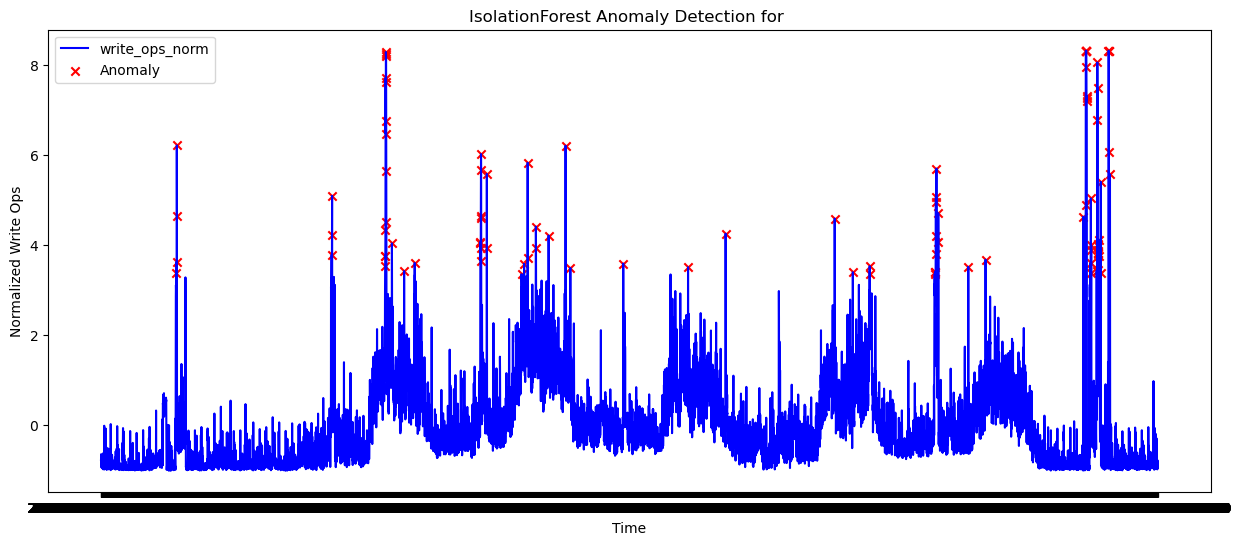

In [13]:
# Plot results
plt.figure(figsize=(15,6))
plt.plot(df_one["timestamp"], df_one["write_ops_norm"], label="write_ops_norm", color="blue")
plt.scatter(df_one.loc[df_one["is_anomaly"]==1, "timestamp"],
            df_one.loc[df_one["is_anomaly"]==1, "write_ops_norm"],
            color="red", marker="x", label="Anomaly")
plt.title(f"IsolationForest Anomaly Detection for ")
plt.xlabel("Time")
plt.ylabel("Normalized Write Ops")
plt.legend()
plt.show()

In [14]:
# Prophet expects specific column names
df_prophet["timestamp"] = pd.to_datetime(df_prophet["timestamp"])
df_prophet.rename(columns={"timestamp": "ds", "write_ops": "y"}, inplace=True)

In [15]:
# Example: 80% train, 20% test
split_point = int(len(df_prophet) * 0.8)

train_df = df_prophet.iloc[:split_point]
test_df  = df_prophet.iloc[split_point:]

In [16]:
model = Prophet(daily_seasonality=True, weekly_seasonality=True)
model.fit(train_df)

11:43:21 - cmdstanpy - INFO - Chain [1] start processing
11:43:22 - cmdstanpy - INFO - Chain [1] done processing


In [17]:
# Make future dataframe long enough to cover the test range
future = model.make_future_dataframe(periods=len(test_df), freq="min")

forecast = model.predict(future)

# Extract only the test part of forecast
forecast_test = forecast.iloc[-len(test_df):][["ds","yhat","yhat_lower","yhat_upper"]]

In [18]:
df_compare = test_df.merge(forecast_test, on="ds")
df_compare.rename(columns={
    "ds": "timestamp",
    "y": "actual_write_ops",
    "yhat": "predicted_write_ops",
    "yhat_lower": "predicted_min",
    "yhat_upper": "predicted_max"
}, inplace=True)

In [19]:
mae = mean_absolute_error(df_compare["actual_write_ops"], df_compare["predicted_write_ops"])
rmse = np.sqrt(mean_squared_error(df_compare["actual_write_ops"], df_compare["predicted_write_ops"]))

print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}")

MAE: 942.14, RMSE: 1165.50


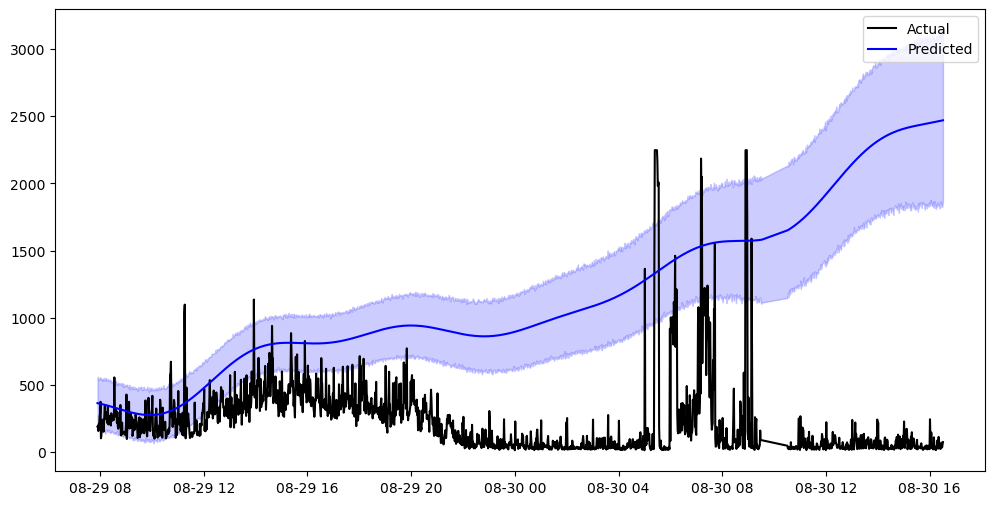

In [20]:
plt.figure(figsize=(12,6))
plt.plot(df_compare["timestamp"], df_compare["actual_write_ops"], label="Actual", color="black")
plt.plot(df_compare["timestamp"], df_compare["predicted_write_ops"], label="Predicted", color="blue")
plt.fill_between(df_compare["timestamp"], df_compare["predicted_min"], df_compare["predicted_max"], color="blue", alpha=0.2)
plt.legend()
plt.show()

In [21]:
df_orig.head()

Unnamed: 0            timestamp                   host  write_ops  \
0           0  2025-08-23 18:31:00  HOST-F52B15BB4B4D209D     68.744   
1           1  2025-08-23 18:32:00  HOST-F52B15BB4B4D209D     82.322   
2           2  2025-08-23 18:33:00  HOST-F52B15BB4B4D209D     99.632   
3           3  2025-08-23 18:34:00  HOST-F52B15BB4B4D209D     52.871   
4           4  2025-08-23 18:35:00  HOST-F52B15BB4B4D209D     46.099   

   write_ops_norm  
0       -0.777823  
1       -0.721135  
2       -0.648867  
3       -0.844092  
4       -0.872365

In [22]:
df_orig['timestamp'] = pd.to_datetime(df_orig['timestamp'])
df_orig = df_orig.set_index('timestamp').sort_index()

In [23]:
# Step 2: Scale values
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(df_orig[['write_ops']])

In [24]:
# Step 3: Create sequences
SEQ_LEN = 60   # past 60 mins
def create_sequences(data, seq_len=SEQ_LEN):
    X, y = [], []
    for i in range(len(data)-seq_len):
        X.append(data[i:i+seq_len])
        y.append(data[i+seq_len])
    return np.array(X), np.array(y)


In [25]:
X, y = create_sequences(data_scaled, SEQ_LEN)

# Step 4: Train-test split
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [26]:
# Model architecture
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(32),
    Dense(1)  # predicting next write_ops
])


In [27]:
model.compile(optimizer='adam', loss='mse')
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=20,
    batch_size=64,
    verbose=1
)

Epoch 1/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 0.0070 - val_loss: 0.0093
Epoch 2/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0031 - val_loss: 0.0076
Epoch 3/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0029 - val_loss: 0.0067
Epoch 4/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.0030 - val_loss: 0.0063
Epoch 5/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0027 - val_loss: 0.0061
Epoch 6/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0027 - val_loss: 0.0059
Epoch 7/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.0026 - val_loss: 0.0058
Epoch 8/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0027 - val_loss: 0.0055
Epoch 9/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.0029 - val_loss: 0.0054
Epoch 10/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.0024 - val_loss: 0.0053
Epoch 11/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0025 - val_loss: 0.0051
Epoch 12/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 

In [28]:
# Predictions
y_pred = model.predict(X_test)

# Inverse scale back to original values
y_test_inv = scaler.inverse_transform(y_test)
y_pred_inv = scaler.inverse_transform(y_pred)

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


In [29]:
mae = mean_absolute_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))

print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}")

MAE: 81.93, RMSE: 157.51


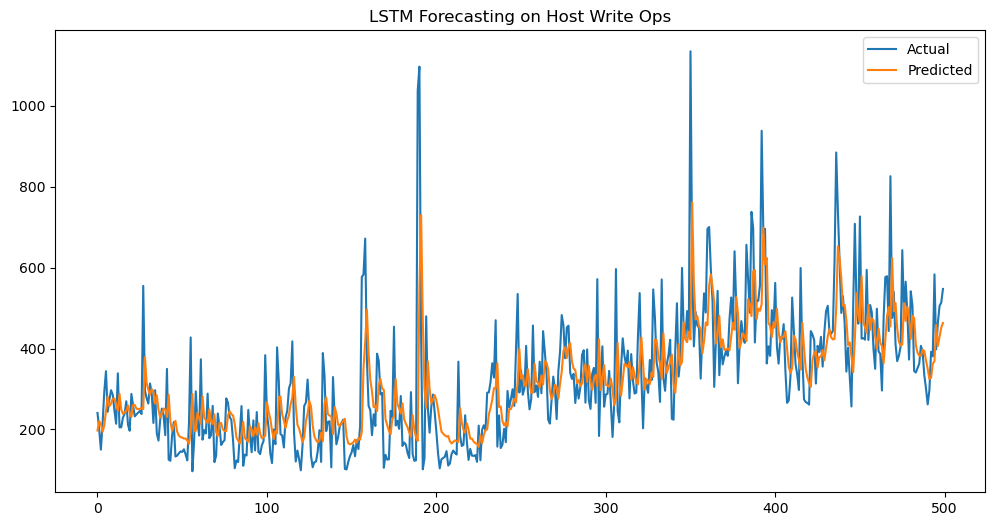

In [30]:
plt.figure(figsize=(12,6))
plt.plot(y_test_inv[:500], label="Actual")      # first 500 points for clarity
plt.plot(y_pred_inv[:500], label="Predicted")
plt.legend()
plt.title("LSTM Forecasting on Host Write Ops")
plt.show()

In [31]:
#tunning hyperparameters
X, y = create_sequences(data_scaled, 120)

# Step 4: Train-test split
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [33]:
# Model architecture
model = Sequential([
    LSTM(64, activation='tanh', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(64, activation='tanh', return_sequences=False),
    Dense(1)  # predicting next write_ops
])

In [34]:
model.compile(optimizer='adam', loss='mse')
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=20,
    batch_size=64,
    verbose=1
)

Epoch 1/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 8s 64ms/step - loss: 0.0054 - val_loss: 0.0082
Epoch 2/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step - loss: 0.0028 - val_loss: 0.0068
Epoch 3/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 8s 64ms/step - loss: 0.0029 - val_loss: 0.0063
Epoch 4/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 8s 65ms/step - loss: 0.0027 - val_loss: 0.0061
Epoch 5/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 8s 64ms/step - loss: 0.0027 - val_loss: 0.0057
Epoch 6/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 8s 63ms/step - loss: 0.0022 - val_loss: 0.0054
Epoch 7/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 8s 63ms/step - loss: 0.0025 - val_loss: 0.0052
Epoch 8/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 8s 64ms/step - loss: 0.0023 - val_loss: 0.0050
Epoch 9/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 8s 64ms/step - loss: 0.0025 - val_loss: 0.0053
Epoch 10/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 8s 65ms/step - loss: 0.0023 - val_loss: 0.0050
Epoch 11/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 8s 65ms/step - loss: 0.0021 - val_loss: 0.0051
Epoch 12/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 

In [35]:
# Predictions
y_pred = model.predict(X_test)

# Inverse scale back to original values
y_test_inv = scaler.inverse_transform(y_test)
y_pred_inv = scaler.inverse_transform(y_pred)

61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


In [36]:
mae = mean_absolute_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))

print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}")

MAE: 86.08, RMSE: 161.45


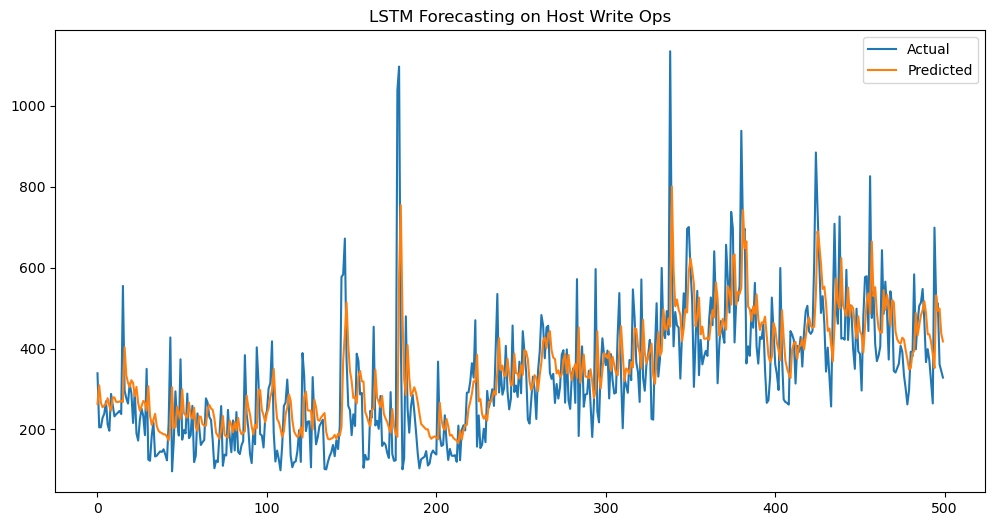

In [37]:
plt.figure(figsize=(12,6))
plt.plot(y_test_inv[:500], label="Actual")      # first 500 points for clarity
plt.plot(y_pred_inv[:500], label="Predicted")
plt.legend()
plt.title("LSTM Forecasting on Host Write Ops")
plt.show()